# Unit 6. Essential Deep Learning Tips & Tricks

# Exercise 1: Learning Rate Warmup

In [3]:
# !pip install lightning-bolts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.8/300.8 kB 6.4 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 15.9 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 2.0.5
    Uninstalling pytorch-lightning-2.0.5:
      Successfully uninstalled pytorch-lightning-2.0.5


In [1]:
%load_ext watermark
%watermark -p torch,lightning,pl_bolts --conda

/opt/homebrew/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch    : 2.0.1
lightning: 2.0.5
pl_bolts : 0.7.0

conda environment: base



/opt/homebrew/anaconda3/lib/python3.10/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/opt/homebrew/anaconda3/lib/python3.10/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:92: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  contrastive_task: Union[FeatureMapContra

In [6]:
import lightning as L
import torch
import torch.nn.functional as F
import torchmetrics
from lightning.pytorch.loggers import CSVLogger
import pl_bolts

from shared_utilities import CustomDataModule, PyTorchMLP

In [3]:
num_epochs = 100

## Cosine annealing with 1-cycle schedule

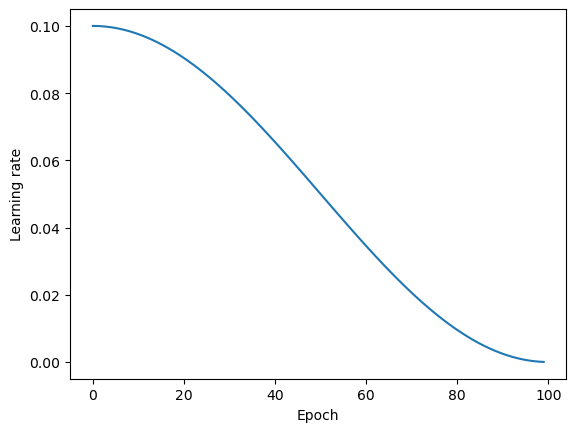

In [4]:
import matplotlib.pyplot as plt

model = torch.nn.Linear(1, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
lrs = []

for i in range(num_epochs):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()

plt.ylabel("Learning rate")
plt.xlabel("Epoch")
plt.plot(lrs)
#plt.savefig("cosine-1cycle-epoch.pdf")
plt.show()

/var/folders/_l/t1bw7ywn48b2cvpmt2g61ycc0000gr/T/ipykernel_51803/2034829979.py:6: UnderReviewWarning: The feature LinearWarmupCosineAnnealingLR is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  scheduler = pl_bolts.optimizers.lr_scheduler.LinearWarmupCosineAnnealingLR(optimizer, warmup_epochs=20, max_epochs=100, warmup_start_lr=0.0, eta_min=0.0, last_epoch=- 1)


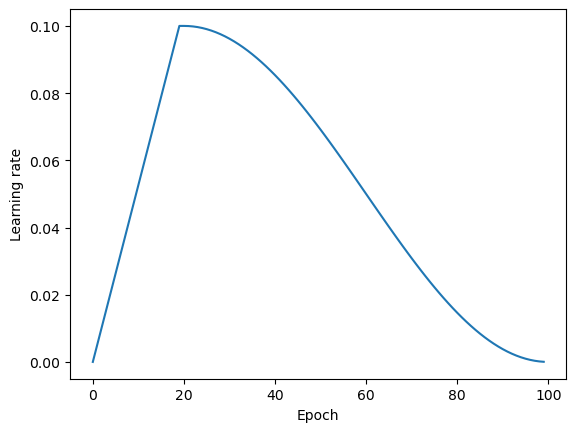

In [7]:
from pl_bolts.optimizers.lr_scheduler import LinearWarmupCosineAnnealingLR


model = torch.nn.Linear(1, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
scheduler = pl_bolts.optimizers.lr_scheduler.LinearWarmupCosineAnnealingLR(optimizer, warmup_epochs=20, max_epochs=100, warmup_start_lr=0.0, eta_min=0.0, last_epoch=- 1)

lrs = []

for i in range(num_epochs):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()

plt.ylabel("Learning rate")
plt.xlabel("Epoch")
plt.plot(lrs)
#plt.savefig("cosine-1cycle-epoch.pdf")
plt.show()

In [13]:
class LightningModel(L.LightningModule):
    def __init__(self, model, learning_rate, num_epochs):  # New!
        super().__init__()

        self.learning_rate = learning_rate
        self.num_epochs = num_epochs  # New!
        self.model = model

        self.save_hyperparameters(ignore=["model"])

        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=2)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=2)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=2)

    def forward(self, x):
        return self.model(x)

    def _shared_step(self, batch):
        features, true_labels = batch
        logits = self(features)

        loss = F.cross_entropy(logits, true_labels)
        predicted_labels = torch.argmax(logits, dim=1)
        return loss, true_labels, predicted_labels

    def training_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)

        self.log("train_loss", loss)
        self.train_acc(predicted_labels, true_labels)
        self.log(
            "train_acc", self.train_acc, prog_bar=True, on_epoch=True, on_step=False
        )
        return loss

    def validation_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)

        self.log("val_loss", loss, prog_bar=True)
        self.val_acc(predicted_labels, true_labels)
        self.log("val_acc", self.val_acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.test_acc(predicted_labels, true_labels)
        self.log("test_acc", self.test_acc)

    def configure_optimizers(self): # New! 
        opt = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        sch = LinearWarmupCosineAnnealingLR(opt, warmup_epochs=20, max_epochs = self.num_epochs)
        #### YOUR CODE USING LinearWarmupCosineAnnealingLR
        # Tip: use self.num_epochs to specify the number of epochs

        return {
            "optimizer": opt,
            "lr_scheduler": {
                "scheduler": sch,
                "monitor": "train_loss",
                "interval": "epoch",
                "frequency": 1,
            },
        }

# !!! No Modification Required Below Here !!!

In [14]:
L.seed_everything(123)
dm = CustomDataModule()

pytorch_model = PyTorchMLP(num_features=100, num_classes=2)
lightning_model = LightningModel(
    model=pytorch_model,
    learning_rate=0.1,
    num_epochs=num_epochs) # New!

trainer = L.Trainer(
    max_epochs=num_epochs,
    accelerator="cpu",
    devices="auto",
    logger=CSVLogger(save_dir="logs/", name="my-model"),
    deterministic=True,
)

Global seed set to 123
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/anaconda3/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


In [15]:
trainer.fit(model=lightning_model, datamodule=dm)

/var/folders/_l/t1bw7ywn48b2cvpmt2g61ycc0000gr/T/ipykernel_51803/2535230130.py:50: UnderReviewWarning: The feature LinearWarmupCosineAnnealingLR is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  sch = LinearWarmupCosineAnnealingLR(opt, warmup_epochs=20, max_epochs = self.num_epochs)

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | PyTorchMLP         | 15.3 K
1 | train_acc | MulticlassAccuracy | 0     
2 | val_acc   | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
15.3 K    Trainable params
0         Non-trainable params
15.3 K    Total params
0.061     Total estimated model params size (MB)


/opt/homebrew/anaconda3/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/homebrew/anaconda3/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 99: 100%|██████████| 450/450 [00:01<00:00, 365.38it/s, v_num=1, val_loss=0.721, val_acc=0.895, train_acc=0.995]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 450/450 [00:01<00:00, 361.23it/s, v_num=1, val_loss=0.721, val_acc=0.895, train_acc=0.995]


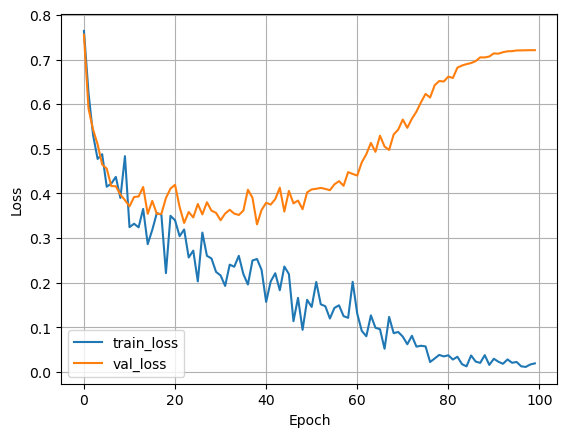

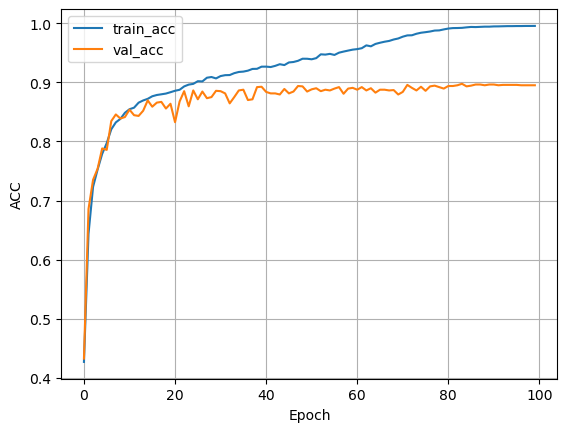

In [17]:
### Plot
import matplotlib.pyplot as plt
import pandas as pd

metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "val_loss"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
)

plt.savefig("suggest_loss.pdf")

df_metrics[["train_acc", "val_acc"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="ACC"
)

plt.savefig("suggest_acc.pdf")

plt.show()

In [18]:
trainer.test(model=lightning_model, datamodule=dm)

/opt/homebrew/anaconda3/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 125/125 [00:00<00:00, 441.34it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8884999752044678     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.8884999752044678}]